# Inverse Probability of Treatment Weighting (IPTW)

**Chapter 11, Section 2**

This notebook covers the IPTW estimator: using propensity scores to reweight the sample.

## Table of Contents
1. [Intuition](#intuition) - Reweighting to create pseudo-population
2. [Formal Treatment](#formal) - IPTW derivation
3. [Numeric Demonstration](#numeric) - Growth mindset application
4. [Implementation](#implementation) - Stabilized weights and inference
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Reweighting Idea

Instead of matching units, IPTW creates a **pseudo-population** where treatment is independent of covariates.

**Problem**: In observational data, $P(T=1|X)$ varies with $X$ (confounding)

**Solution**: Weight each observation to make the sample "look like" an RCT

### How It Works

For treated units with high propensity score:
- They were "likely" to be treated anyway
- **Down-weight** them (not representative of all treated units)

For treated units with low propensity score:
- They were "unlikely" to be treated
- **Up-weight** them (represent many others who weren't treated)

Same logic for control units (flip the weights).

### The Weight Formula

$$w_i = \frac{T_i}{e(X_i)} + \frac{1-T_i}{1-e(X_i)}$$

- Treated units: $w_i = 1/e(X_i)$ (inverse of treatment probability)
- Control units: $w_i = 1/(1-e(X_i))$ (inverse of control probability)

---

In [2]:
# Load data and estimate propensity scores
mindset = load_facure_data("learning_mindset.csv")

covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

X = mindset[covariates].values
T = mindset['intervention'].values
Y = mindset['achievement_score'].values

# Estimate propensity scores
ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]

print(f"Data: {len(mindset)} students")
print(f"PS range: [{ps.min():.4f}, {ps.max():.4f}]")

Data: 10391 students
PS range: [0.1818, 0.4551]


In [3]:
# Compute IPW weights
weights = T / ps + (1 - T) / (1 - ps)

print("IPW WEIGHTS:")
print("=" * 50)
print(f"\nTreated weights (1/e(X)):")
print(f"  Min:  {weights[T==1].min():.3f}")
print(f"  Max:  {weights[T==1].max():.3f}")
print(f"  Mean: {weights[T==1].mean():.3f}")

print(f"\nControl weights (1/(1-e(X))):")
print(f"  Min:  {weights[T==0].min():.3f}")
print(f"  Max:  {weights[T==0].max():.3f}")
print(f"  Mean: {weights[T==0].mean():.3f}")

IPW WEIGHTS:

Treated weights (1/e(X)):
  Min:  2.203
  Max:  4.880
  Mean: 3.070

Control weights (1/(1-e(X))):
  Min:  1.222
  Max:  1.835
  Mean: 1.483


---

## Formal Treatment

### IPTW Estimator

**Theorem** (Horvitz-Thompson Estimator):

Under conditional ignorability and positivity:

$$\hat{\tau}_{IPTW} = \frac{1}{n}\sum_i \frac{T_i Y_i}{e(X_i)} - \frac{1}{n}\sum_i \frac{(1-T_i) Y_i}{1-e(X_i)}$$

is an unbiased estimator of the ATE.

### Derivation

**Step 1**: For treated potential outcome:
$$E\left[\frac{T_i Y_i}{e(X_i)}\right] = E\left[E\left[\frac{T_i Y_i}{e(X_i)} \mid X_i\right]\right]$$

**Step 2**: Conditional on $X_i$:
$$E\left[\frac{T_i Y_i}{e(X_i)} \mid X_i\right] = \frac{1}{e(X_i)} E[T_i Y_i | X_i]$$

**Step 3**: Since $E[T_i | X_i] = e(X_i)$ and by ignorability:
$$= \frac{1}{e(X_i)} \cdot e(X_i) \cdot E[Y_i(1) | X_i] = E[Y_i(1) | X_i]$$

**Step 4**: Taking outer expectation:
$$E\left[\frac{T_i Y_i}{e(X_i)}\right] = E[Y_i(1)]$$

Similarly for control: $E\left[\frac{(1-T_i) Y_i}{1-e(X_i)}\right] = E[Y_i(0)]$

Therefore:
$$E[\hat{\tau}_{IPTW}] = E[Y(1)] - E[Y(0)] = \tau_{ATE}$$

---

In [4]:
# Implement basic IPTW
def iptw_ate(Y, T, ps):
    """
    Horvitz-Thompson IPTW estimator for ATE.
    """
    n = len(Y)
    
    # Mean of weighted outcomes
    mu1 = np.sum(T * Y / ps) / n
    mu0 = np.sum((1 - T) * Y / (1 - ps)) / n
    
    return mu1 - mu0

ate_iptw = iptw_ate(Y, T, ps)
print(f"IPTW ATE: {ate_iptw:.4f}")

IPTW ATE: 0.3946


In [5]:
# Hajek (normalized) estimator - more stable
def hajek_ate(Y, T, ps):
    """
    Hajek (normalized) IPTW estimator.
    Normalizes by sum of weights instead of n.
    """
    # Weighted mean for treated
    mu1 = np.sum(T * Y / ps) / np.sum(T / ps)
    
    # Weighted mean for control
    mu0 = np.sum((1 - T) * Y / (1 - ps)) / np.sum((1 - T) / (1 - ps))
    
    return mu1 - mu0

ate_hajek = hajek_ate(Y, T, ps)

print("IPTW ESTIMATES:")
print("=" * 50)
print(f"Horvitz-Thompson: {ate_iptw:.4f}")
print(f"Hajek (normalized): {ate_hajek:.4f}")
print(f"\nHajek is generally preferred (more stable with extreme weights)")

IPTW ESTIMATES:
Horvitz-Thompson: 0.3946
Hajek (normalized): 0.3946

Hajek is generally preferred (more stable with extreme weights)


---

## Numeric Demonstration

### Visualizing the Reweighting

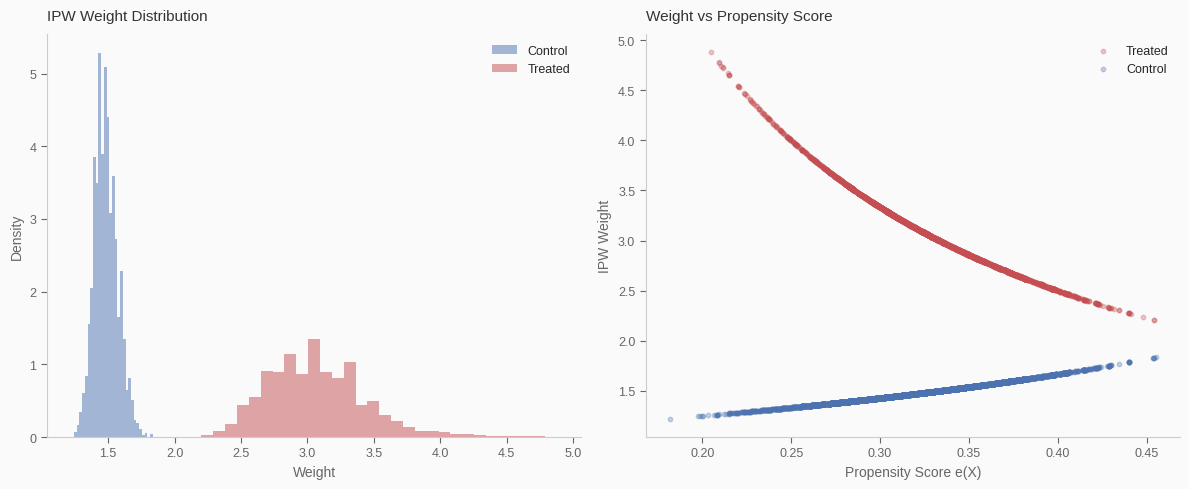

Treated with low PS get high weights (unlikely to be treated).
Control with high PS get high weights (unlikely to be control).


In [6]:
# Visualize weight distribution
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Weight distribution by treatment
ax = axes[0]
ax.hist(weights[T==0], bins=30, alpha=0.5, color=COLORS['blue'], label='Control', density=True)
ax.hist(weights[T==1], bins=30, alpha=0.5, color=COLORS['red'], label='Treated', density=True)
set_tufte_title(ax, "IPW Weight Distribution")
set_tufte_labels(ax, "Weight", "Density")
ax.legend(frameon=False)

# Right: Weight vs propensity score
ax = axes[1]
ax.scatter(ps[T==1], weights[T==1], alpha=0.3, s=10, c=COLORS['red'], label='Treated')
ax.scatter(ps[T==0], weights[T==0], alpha=0.3, s=10, c=COLORS['blue'], label='Control')
set_tufte_title(ax, "Weight vs Propensity Score")
set_tufte_labels(ax, "Propensity Score e(X)", "IPW Weight")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("Treated with low PS get high weights (unlikely to be treated).")
print("Control with high PS get high weights (unlikely to be control).")

In [7]:
# Check balance after weighting
def weighted_mean(x, w, t, treatment_value):
    """Compute weighted mean for a treatment group."""
    mask = t == treatment_value
    return np.average(x[mask], weights=w[mask])

print("COVARIATE BALANCE AFTER WEIGHTING:")
print("=" * 70)
print(f"\n{'Covariate':<25} {'Unweighted Diff':<18} {'Weighted Diff'}")
print("-" * 70)

for cov in covariates:
    x = mindset[cov].values
    
    # Unweighted difference
    unweighted_diff = x[T==1].mean() - x[T==0].mean()
    
    # Weighted difference
    weighted_treated = weighted_mean(x, weights, T, 1)
    weighted_control = weighted_mean(x, weights, T, 0)
    weighted_diff = weighted_treated - weighted_control
    
    print(f"{cov:<25} {unweighted_diff:+.4f}           {weighted_diff:+.4f}")

print(f"\nWeighting dramatically improves covariate balance!")

COVARIATE BALANCE AFTER WEIGHTING:

Covariate                 Unweighted Diff    Weighted Diff
----------------------------------------------------------------------
success_expect            +0.1405           -0.0008
ethnicity                 -0.0552           +0.0074
gender                    -0.0272           -0.0000
frst_in_family            -0.0465           -0.0008
school_mindset            -0.0954           -0.0005
school_achievement        +0.0557           +0.0008
school_ethnic_minority    -0.0046           -0.0004
school_poverty            -0.0241           -0.0020
school_size               +0.0738           +0.0022

Weighting dramatically improves covariate balance!


---

## Implementation

### Stabilized Weights

In [8]:
# Stabilized weights - reduce variance
def stabilized_weights(T, ps):
    """
    Stabilized IPW weights.
    Multiply standard weights by marginal treatment probability.
    """
    p_t = T.mean()  # Marginal P(T=1)
    
    # Stabilized weights
    sw = T * (p_t / ps) + (1 - T) * ((1 - p_t) / (1 - ps))
    
    return sw

sw = stabilized_weights(T, ps)

print("STABILIZED vs STANDARD WEIGHTS:")
print("=" * 50)
print(f"\nStandard weights:")
print(f"  Mean: {weights.mean():.3f}")
print(f"  Std:  {weights.std():.3f}")
print(f"  Max:  {weights.max():.3f}")

print(f"\nStabilized weights:")
print(f"  Mean: {sw.mean():.3f}")
print(f"  Std:  {sw.std():.3f}")
print(f"  Max:  {sw.max():.3f}")

print(f"\nStabilized weights have mean ~1 and lower variance.")

STABILIZED vs STANDARD WEIGHTS:

Standard weights:
  Mean: 2.000
  Std:  0.778
  Max:  4.880

Stabilized weights:
  Mean: 1.000
  Std:  0.085
  Max:  1.589

Stabilized weights have mean ~1 and lower variance.


In [9]:
# Bootstrap standard errors for IPTW
def bootstrap_iptw(Y, T, X, n_bootstrap=500, alpha=0.05):
    """
    Bootstrap confidence intervals for IPTW ATE.
    """
    n = len(Y)
    estimates = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        idx = np.random.choice(n, n, replace=True)
        Y_boot = Y[idx]
        T_boot = T[idx]
        X_boot = X[idx]
        
        # Re-estimate propensity scores
        ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
        ps_model.fit(X_boot, T_boot)
        ps_boot = ps_model.predict_proba(X_boot)[:, 1]
        
        # Compute IPTW estimate
        ate_boot = hajek_ate(Y_boot, T_boot, ps_boot)
        estimates.append(ate_boot)
    
    estimates = np.array(estimates)
    
    return {
        'ate': np.mean(estimates),
        'se': np.std(estimates),
        'ci_lower': np.percentile(estimates, 100 * alpha / 2),
        'ci_upper': np.percentile(estimates, 100 * (1 - alpha / 2))
    }

print("Computing bootstrap CI (this may take a moment)...")
np.random.seed(42)
boot_result = bootstrap_iptw(Y, T, X, n_bootstrap=200)

print(f"\nBOOTSTRAP RESULTS:")
print("=" * 50)
print(f"ATE: {boot_result['ate']:.4f}")
print(f"SE:  {boot_result['se']:.4f}")
print(f"95% CI: [{boot_result['ci_lower']:.4f}, {boot_result['ci_upper']:.4f}]")

Computing bootstrap CI (this may take a moment)...



BOOTSTRAP RESULTS:
ATE: 0.3945
SE:  0.0185
95% CI: [0.3598, 0.4253]


In [10]:
# Final comparison
print("\nFINAL COMPARISON OF ESTIMATES:")
print("=" * 60)

# Naive
naive = Y[T==1].mean() - Y[T==0].mean()
print(f"Naive (no adjustment):     {naive:.4f}")

# Regression
formula = 'achievement_score ~ intervention + ' + ' + '.join(covariates)
mindset_copy = mindset.copy()
reg = smf.ols(formula, data=mindset_copy).fit()
print(f"Regression adjusted:       {reg.params['intervention']:.4f} (SE: {reg.bse['intervention']:.4f})")

# IPTW
print(f"IPTW (Hajek):              {ate_hajek:.4f} (SE: {boot_result['se']:.4f})")

print(f"\nAll methods give similar estimates when model is well-specified.")


FINAL COMPARISON OF ESTIMATES:
Naive (no adjustment):     0.4723
Regression adjusted:       0.3986 (SE: 0.0179)
IPTW (Hajek):              0.3946 (SE: 0.0185)

All methods give similar estimates when model is well-specified.


---

## Interview Appendix

### Practice Questions

**Q1: What is the intuition behind inverse probability weighting?**

<details>
<summary>Solution</summary>

**Core intuition**: Create a pseudo-population where treatment is independent of covariates.

**How it works**:

1. **Treated unit with high PS**: "Expected" to be treated → down-weight (represents few others)

2. **Treated unit with low PS**: "Surprising" to be treated → up-weight (represents many others who weren't treated)

3. **Control unit with low PS**: "Expected" to be control → down-weight

4. **Control unit with high PS**: "Surprising" to be control → up-weight

**Mathematical intuition**:

$$E\left[\frac{TY}{e(X)}\right] = E\left[\frac{P(T=1|X) \cdot Y(1)}{P(T=1|X)}\right] = E[Y(1)]$$

The propensity score in the denominator "cancels out" the selection mechanism, recovering the marginal mean.

**Analogy**: Survey sampling - if certain subgroups are underrepresented, we up-weight them to recover population statistics.

</details>

**Q2: What are the problems with IPTW and how do you address them?**

<details>
<summary>Solution</summary>

**Problem 1: Extreme Weights**

When $e(X) \approx 0$ or $e(X) \approx 1$, weights become huge.

*Solutions*:
- **Stabilized weights**: Multiply by marginal treatment probability
- **Weight trimming**: Cap weights at some percentile (e.g., 99th)
- **Overlap enforcement**: Exclude units with extreme PS

**Problem 2: Model Dependence**

IPTW relies on correct PS model specification.

*Solutions*:
- Check balance after weighting
- Try different PS models (logistic, GBM, etc.)
- Use doubly robust methods (Chapter 12)

**Problem 3: Variance**

IPTW can have high variance, especially with extreme weights.

*Solutions*:
- Use Hajek (normalized) estimator
- Stabilized weights
- Bootstrap for variance estimation

**Problem 4: Positivity Violation**

If $e(X) = 0$ or $e(X) = 1$ for some $X$, IPTW is undefined.

*Solutions*:
- Trim the sample to common support
- Report on excluded units
- Consider bounds on treatment effect

</details>

**Q3: What is the difference between Horvitz-Thompson and Hajek estimators?**

<details>
<summary>Solution</summary>

**Horvitz-Thompson (HT)**:

$$\hat{\mu}_1^{HT} = \frac{1}{n}\sum_i \frac{T_i Y_i}{e(X_i)}$$

- Divides by sample size $n$
- Unbiased for $E[Y(1)]$
- Can give nonsensical results if weights are extreme

**Hajek (Normalized)**:

$$\hat{\mu}_1^{Hajek} = \frac{\sum_i T_i Y_i / e(X_i)}{\sum_i T_i / e(X_i)}$$

- Divides by sum of weights
- Slightly biased but much lower variance
- Always gives reasonable results (weighted average)

**When to use each**:
- **HT**: When you need unbiasedness and weights are well-behaved
- **Hajek**: Almost always preferred in practice (more stable)

**Key insight**: The Hajek estimator is essentially a weighted mean, which is always in the range of observed values. The HT estimator can extrapolate beyond this range.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 11.

[^2]: Horvitz, D. G., & Thompson, D. J. (1952). A generalization of sampling without replacement from a finite universe. *JASA*, 47(260), 663-685.

[^3]: Robins, J. M., Rotnitzky, A., & Zhao, L. P. (1994). Estimation of regression coefficients when some regressors are not always observed. *JASA*, 89(427), 846-866.

[^4]: Cross-reference: Doubly robust estimation in `12_doubly_robust/01_dr_estimator.ipynb`